In [ ]:
import os
import warnings
import shutil
warnings.filterwarnings(action='ignore')
import argparse
import math
import pandas as pd
import librosa
import librosa.display
import numpy as np
import seaborn as sns; sns.set(style='whitegrid')
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from PIL import Image
from tqdm import tqdm,tnrange,tqdm_notebook
import tensorflow as tf
from tqdm.keras import TqdmCallback
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import applications as app
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,AveragePooling2D
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential 
import pickle
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report



In [ ]:
# Global vars
RANDOM_SEED = 1337
SAMPLE_RATE = 32000
SIGNAL_LENGTH = 5 # seconds
SPEC_SHAPE = (224, 224) # height x width
FMIN = 500
FMAX = 12500
# MAX_AUDIO_FILES = 10000
EPOCHS=10

In [ ]:
# Load metadata file
train = pd.read_csv('../input/birdclef-2022/train_metadata.csv',)


EDA

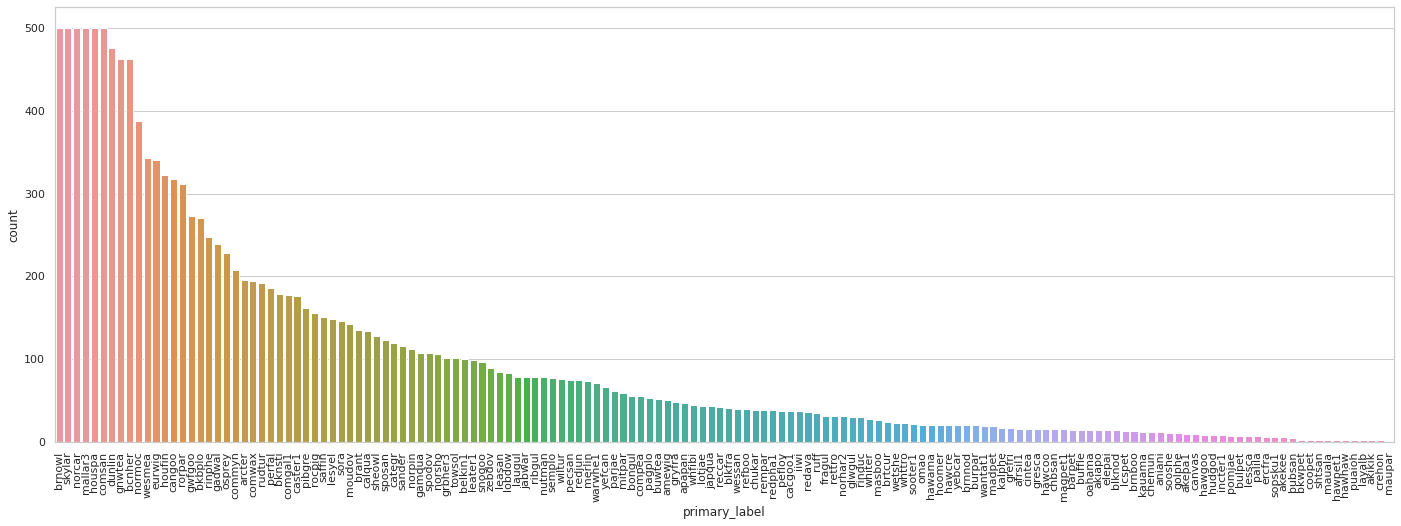

In [ ]:
fig, ax = plt.subplots(figsize=(24, 8))
sns.countplot(data= train, x='primary_label', ax=ax, order= train['primary_label'].value_counts().index)
plt.xticks(rotation=90);

In [ ]:
train.primary_label.unique()

array(['afrsil1', 'akekee', 'akepa1', 'akiapo', 'akikik', 'amewig',
       'aniani', 'apapan', 'arcter', 'barpet', 'bcnher', 'belkin1',
       'bkbplo', 'bknsti', 'bkwpet', 'blkfra', 'blknod', 'bongul',
       'brant', 'brnboo', 'brnnod', 'brnowl', 'brtcur', 'bubsan',
       'buffle', 'bulpet', 'burpar', 'buwtea', 'cacgoo1', 'calqua',
       'cangoo', 'canvas', 'caster1', 'categr', 'chbsan', 'chemun',
       'chukar', 'cintea', 'comgal1', 'commyn', 'compea', 'comsan',
       'comwax', 'coopet', 'crehon', 'dunlin', 'elepai', 'ercfra',
       'eurwig', 'fragul', 'gadwal', 'gamqua', 'glwgul', 'gnwtea',
       'golphe', 'grbher3', 'grefri', 'gresca', 'gryfra', 'gwfgoo',
       'hawama', 'hawcoo', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1',
       'hoomer', 'houfin', 'houspa', 'hudgod', 'iiwi', 'incter1',
       'jabwar', 'japqua', 'kalphe', 'kauama', 'laugul', 'layalb',
       'lcspet', 'leasan', 'leater1', 'lessca', 'lesyel', 'lobdow',
       'lotjae', 'madpet', 'magpet1', 'mallar3', 'masboo

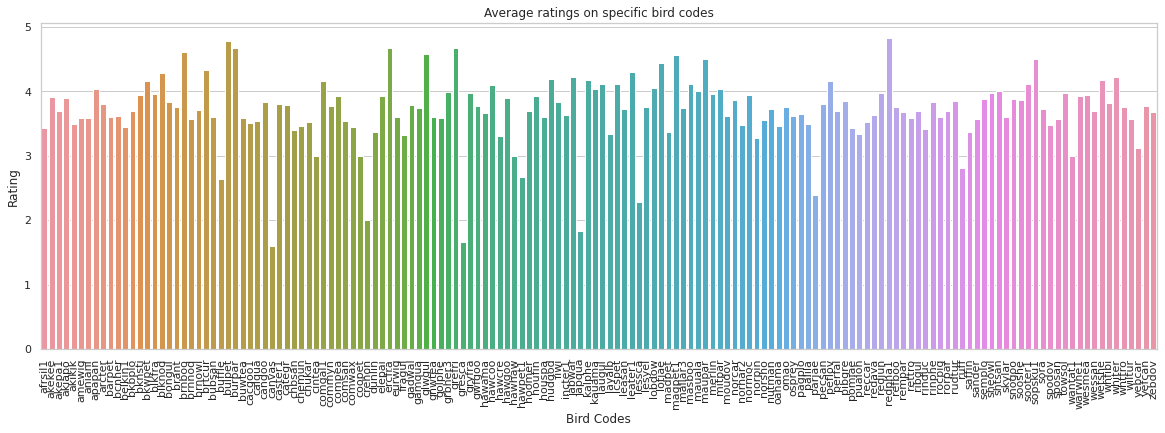

In [ ]:
avg_ratings = train.groupby("primary_label").agg({"rating" : "mean"})
plt.figure(figsize = (20, 6))
sns.barplot(avg_ratings.index, avg_ratings.rating)
plt.title("Average ratings on specific bird codes")
plt.xlabel("Bird Codes")
plt.ylabel("Rating")
plt.xticks(rotation = 90)
plt.show()

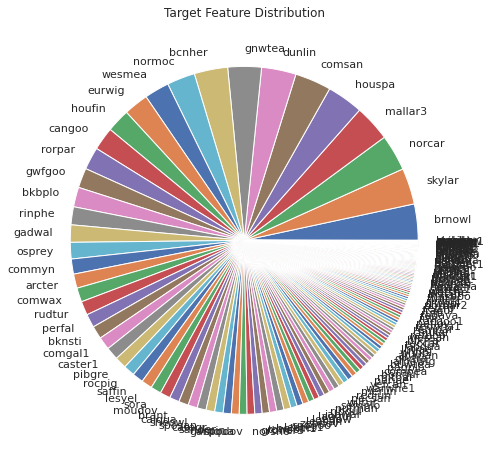

In [ ]:
target_feature_dist = train.primary_label.value_counts()
plt.figure(figsize = (8, 8))
plt.pie(target_feature_dist.values, labels= target_feature_dist.index)
plt.title("Target Feature Distribution")
plt.show()

In [ ]:

# Limit the number of training samples and classes
# First, only use high quality samples
train = train.query('rating>=4')

# Second, assume that birds with the most training samples are also the most common
# A species needs at least 200 recordings with a rating above 4 to be considered common
birds_count = {}
for bird_species, count in zip(train.primary_label.unique(), 
                               train.groupby('primary_label')['primary_label'].count().values):
    birds_count[bird_species] = count
most_represented_birds = [key for key,value in birds_count.items() if value >= 175] 

TRAIN = train.query('primary_label in @most_represented_birds')
LABELS = sorted(TRAIN.primary_label.unique())

# Let's see how many species and samples we have left
print('NUMBER OF SPECIES IN TRAIN DATA:', len(LABELS))
print('NUMBER OF SAMPLES IN TRAIN DATA:', len(TRAIN))
print('LABELS:', most_represented_birds)

NUMBER OF SPECIES IN TRAIN DATA: 16
NUMBER OF SAMPLES IN TRAIN DATA: 3919
LABELS: ['bcnher', 'brnowl', 'cangoo', 'comsan', 'dunlin', 'eurwig', 'gnwtea', 'houfin', 'houspa', 'mallar3', 'norcar', 'normoc', 'rinphe', 'rorpar', 'skylar', 'wesmea']


In [ ]:
# saving labels 
with open('LABELS.pkl','wb') as f:
    pickle.dump(LABELS,f)

In [ ]:
# Shuffle the training data and limit the number of audio files to MAX_AUDIO_FILES
TRAIN = shuffle(TRAIN, random_state=RANDOM_SEED)

# Define a function that splits an audio file, 
# extracts spectrograms and saves them in a working directory
def get_spectrograms(filepath, primary_label, output_dir):
    
    # Open the file with librosa (limited to the first 15 seconds)
    sig, rate = librosa.load(filepath, sr=SAMPLE_RATE, offset=None, duration=15)
    
    # Split signal into five second chunks
    sig_splits = []
    for i in range(0, len(sig), int(SIGNAL_LENGTH * SAMPLE_RATE)):
        split = sig[i:i + int(SIGNAL_LENGTH * SAMPLE_RATE)]

        # End of signal?
        if len(split) < int(SIGNAL_LENGTH * SAMPLE_RATE):
            break
        
        sig_splits.append(split)
        
    # Extract mel spectrograms for each audio chunk
    s_cnt = 0
    saved_samples = []
    for chunk in sig_splits:
        
        hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
        mel_spec = librosa.feature.melspectrogram(y=chunk, 
                                                  sr=SAMPLE_RATE, 
                                                  n_fft=1024, 
                                                  hop_length=hop_length, 
                                                  n_mels=SPEC_SHAPE[0], 
                                                  fmin=FMIN, 
                                                  fmax=FMAX)
    
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max) 
        
        # Normalize
        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()
        
        # Save as image file
        save_dir = os.path.join(output_dir, primary_label)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, filepath.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0] + 
                                 '_' + str(s_cnt) + '.png')
        im = Image.fromarray(mel_spec * 255.0).convert("L")
        im.save(save_path)
        
        saved_samples.append(save_path)
        s_cnt += 1
        
        
    return saved_samples

print('FINAL NUMBER OF AUDIO FILES IN TRAINING DATA:', len(TRAIN))

FINAL NUMBER OF AUDIO FILES IN TRAINING DATA: 3919


In [ ]:
# Parse audio files and extract training samples
input_dir = '../input/birdclef-2022/train_audio'
output_dir = '../working/melspectrogram_dataset/'
samples = []
with tqdm(total=len(TRAIN)) as pbar:
    for idx, row in TRAIN.iterrows():
        pbar.update(1)
        
        if row.primary_label in most_represented_birds:
            audio_file_path = os.path.join(input_dir, row.filename)
            samples += get_spectrograms(audio_file_path, row.primary_label, output_dir)
            
TRAIN_SPECS = shuffle(samples, random_state=RANDOM_SEED)
print('SUCCESSFULLY EXTRACTED {} SPECTROGRAMS'.format(len(TRAIN_SPECS)))

100%|██████████| 3919/3919 [06:55<00:00,  9.44it/s]

SUCCESSFULLY EXTRACTED 9539 SPECTROGRAMS


In [ ]:

train_folder = './melspectrogram_dataset'
# valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(train_folder, 
#                         target_size=(coefs.sshape[0],coefs.sshape[1]),  # target size
                        target_size=(224,224),
                        batch_size=64, 
                        seed=2022,
                        shuffle=True,
                        subset = "training",
                        class_mode='categorical')    # batch size
validation_generator = datagen.flow_from_directory(train_folder, 
#                         target_size=(coefs.sshape[0],coefs.sshape[1]),  # target size
                        target_size=(224,224),
                        batch_size=64,
                        seed=2022,
                        shuffle=True,
                        subset = "validation",
                        class_mode='categorical')    # batch size

Found 7637 images belonging to 16 classes.
Found 1902 images belonging to 16 classes.


In [ ]:
import cv2
img = cv2.imread('./melspectrogram_dataset/brnowl/XC635289_2.png')

img.shape

(224, 224, 3)

In [ ]:
LEARNING_RATE = 0.001
num_epochs = 10
BATCH_SIZE = 64
IMG_SIZE = 224

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, LSTM, SimpleRNN, Conv1D, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50

CNN

In [ ]:
def My_CNNmodel():

  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu', input_shape=(224,224, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(16, activation='sigmoid'))

  opt=tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=opt,
              loss='binary_crossentropy', # loss='categorical_crossentropy' if softmax
              metrics=['accuracy'])

  return model

In [ ]:
model=My_CNNmodel()
model.summary()

2022-04-09 13:16:05.161479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        1

2022-04-09 13:16:05.248132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 13:16:05.248916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 13:16:05.250113: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-09 13:16:05.251223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer='adam')

In [ ]:
history = model.fit(train_generator,
          epochs = 5, 
          validation_data=validation_generator)

2022-04-09 13:16:11.204523: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-04-09 13:16:13.433876: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


120/120 [==============================] - 119s 933ms/step - loss: 9.5532 - val_loss: 2.6444
Epoch 2/5
120/120 [==============================] - 111s 927ms/step - loss: 2.4904 - val_loss: 2.4764
Epoch 3/5
120/120 [==============================] - 111s 918ms/step - loss: 2.3564 - val_loss: 2.3871
Epoch 4/5
120/120 [==============================] - 111s 923ms/step - loss: 2.2079 - val_loss: 2.2721
Epoch 5/5
120/120 [==============================] - 110s 917ms/step - loss: 2.1390 - val_loss: 2.3039


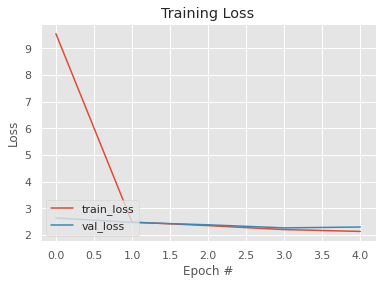

In [ ]:
H = history
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

In [ ]:
model.save('bird_model_cnn.h5')

Resnet 50

In [ ]:
 
base_model = ResNet50(weights='imagenet',include_top=False, input_shape=(224,224,3))

# Construct the head of the model that will be placed on top of the base model
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(16, activation="softmax")(head_model)
model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers:
    layer.trainable = True
model.summary()
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])


H = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=num_epochs)

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

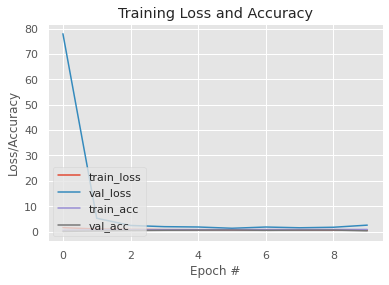

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(H.history["accuracy"])), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(H.history["val_accuracy"])), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
model.save('bird_model_resnet50.h5')

EfficientNetB0

In [ ]:
 
base_model = EfficientNetB0(weights='imagenet',include_top=False, input_shape=(224,224,3))

# Construct the head of the model that will be placed on top of the base model
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(16, activation="softmax")(head_model)
model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers:
    layer.trainable = True
model.summary()
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

H = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=num_epochs)

16719872/16705208 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
___________________________

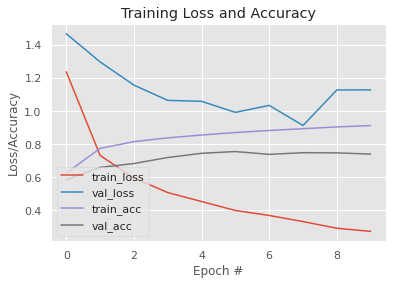

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(H.history["accuracy"])), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(H.history["val_accuracy"])), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
model.save('bird_model_efficientnetB0.h5')

In [ ]:
test_audio_dir = '../input/birdclef-2022/test_soundscapes/'
file_list = [f.split('.')[0] for f in sorted(os.listdir(test_audio_dir))]

print('Number of test soundscapes:', len(file_list))

Number of test soundscapes: 1


In [ ]:
import json
with open('../input/birdclef-2022/scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)

In [ ]:
def predict(threshold):
#     row_id = []
    pred = {'row_id': [], 'target': []}
    scnt = 0
    for afile in file_list:
        # Open it with librosa
        path = test_audio_dir + afile + '.ogg'
        sig, rate = librosa.load(path, sr=SAMPLE_RATE)
        sig_splits = []
        for i in range(0, len(sig), int(SIGNAL_LENGTH * SAMPLE_RATE)):
            split = sig[i:i + int(SIGNAL_LENGTH * SAMPLE_RATE)]

            # End of signal?
            if len(split) < int(SIGNAL_LENGTH * SAMPLE_RATE):
                break

            sig_splits.append(split)

        seconds= 0
        for chunk in sig_splits:

            # Keep track of the end time of each chunk
            seconds += 5

            # Get the spectrogram
            hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
            mel_spec = librosa.feature.melspectrogram(y=chunk, 
                                                      sr=SAMPLE_RATE, 
                                                      n_fft=1024, 
                                                      hop_length=hop_length, 
                                                      n_mels=SPEC_SHAPE[0], 
                                                      fmin=FMIN, 
                                                      fmax=FMAX)

            mel_spec = librosa.power_to_db(mel_spec, ref=np.max) 

            # Normalize to match the value range we used during training.
            # That's something you should always double check!
            mel_spec -= mel_spec.min()
            mel_spec /= mel_spec.max()

            # Add channel axis to 2D array
            mel_spec = np.expand_dims(mel_spec, -1)

            # Add new dimension for batch size
            mel_spec = np.expand_dims(mel_spec, 0)

            # Predict
            p = 0.5*model.predict(mel_spec)[0] 

            # Get highest scoring species
            idx = p.argmax()
            species = LABELS[idx]
            score = p[idx]
            chunks = [[] for i in range(12)]
            for idx,i in enumerate(range(len(chunks))):        
                for bird in scored_birds:
                    chunk_end_time = (i + 1) * 5
                # Prepare submission entry
                    row_id = afile + '_' + bird + '_' + str(chunk_end_time)
#                     row_id.append(afile.split(os.sep)[-1].rsplit('_', 1)[0] + 
#                                   '_' + str(seconds))  
                    # Decide if it's a "nocall" or a species by applying a threshold
#                     pred['row_id'].append(row_id)
#                     pred['target'].append(True if score > threshold else False)
            
                    pred['row_id'].append(row_id)
                    pred['target'].append(True if score > threshold else False)
                       

    result = pd.DataFrame(pred, columns = ['row_id', 'target'])
    return result

In [ ]:
result=predict(0.3)
result

,row_id,target
0,soundscape_453028782_akiapo_5,False
1,soundscape_453028782_aniani_5,False
2,soundscape_453028782_apapan_5,False
3,soundscape_453028782_barpet_5,False
4,soundscape_453028782_crehon_5,False
...,...,...
3019,soundscape_453028782_omao_60,False
3020,soundscape_453028782_puaioh_60,False
3021,soundscape_453028782_skylar_60,False
3022,soundscape_453028782_warwhe1_60,False


In [ ]:
result
results = result.to_csv('submission_bird.csv',index=False)

In [ ]:
results = pd.read_csv('./submission_bird.csv')
results

,row_id,target
0,soundscape_453028782_akiapo_5,False
1,soundscape_453028782_aniani_5,False
2,soundscape_453028782_apapan_5,False
3,soundscape_453028782_barpet_5,False
4,soundscape_453028782_crehon_5,False
...,...,...
3019,soundscape_453028782_omao_60,False
3020,soundscape_453028782_puaioh_60,False
3021,soundscape_453028782_skylar_60,False
3022,soundscape_453028782_warwhe1_60,False
